# 1.7 Small World Network

This notebook shows the solution to Exercise 1.7 from Sethna's book on Statistical mechanics, the idea is creating software that models small world networks and exploring its properties.

## a) Define and show a network object on the computer

The SmallNetwork.py code is completely my "invention", while the NetGraphics code (check the github repository at https://github.com/ijpulidos/StatMech ) is from Sethna's website, I just changed some things to work with recent versions of python3, Pillow and my SmallNetwork code.

The SmallNetwork.py code defines and has the basic functions for the SmallNetwork (graph). The NetGraphics.py code draws the network.

In [1]:
import SmallNetwork  # Local dir lib
import NetGraphics  # Local dir lib 
import numpy as np

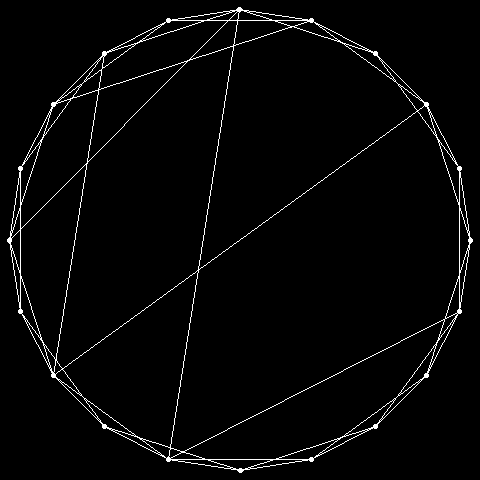

In [2]:
network = SmallNetwork.SmallNetwork(20, 4, 0.2)
NetGraphics.GenerateCircleGraphImage(network, "/tmp/prueba.png")
# NetGraphics.Display("/tmp/prueba.png")

## b) Path length distribution

The idea is to use a *breadth-first* algorithm to compute and save the distances between nodes, just as the book suggests. Now, I did have trouble understanding what the algorithm really does... this should help: https://en.wikipedia.org/wiki/Breadth-first_search

The key aspect is storing the visited nodes and checking if you have already visited the node, then if you just check all the neighbors of all the nodes you get the distance to every node in the network from a given source node, it helps that the network has all the nodes connected one way or the other (ie. there's always a path from one node to any other node). This little animation should help visualizing the algorithm:
<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif">

In [3]:
def FindPathLengthsFromNode(graph, node):
    lengths = {} # Dictionary that will store lenghts from specified node
    l = 0  # Initialize length as zero
    lengths[node] = 0  # Put the length in the correct index (which represents a node) 
                         # lengths[node]-> shortest length to node from origin/source
    currentShell = [node]
    while(True):
        #print(lengths)
        if len(lengths) == len(graph.nodes):
            #print("RETORNA:")
            return lengths
        else:
            for node_ in currentShell:
                #print("Entro currentShell")
                nextShell = []  # Restarting next shell in each iteration
                for neighbor in graph.get_neighbors(node_):
                    #print("Entro neighbor")
                    if neighbor not in lengths:  # Verify that neighbor node has not been visited
                        # Add neighbors of node_ to nextShell
                        nextShell.append(neighbor)
                        # Set distance to node to l+1
                        lengths[neighbor] = l+1
            l+=1
            currentShell = nextShell  # Update shell

In [4]:
FindPathLengthsFromNode(network, 4)

KeyboardInterrupt: 

In [ ]:
SmallNetwork.FindPathLengthsFromNode(network, 4)

In [ ]:
network.get_neighbors(6)

In [ ]:
network.add_node(49)

In [ ]:
network.get_neighbors(49)